In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from scipy.interpolate import UnivariateSpline, interp1d
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.libqsturng import psturng
import scipy.stats as stats

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures

# Make a folder to store cleaned up data frames for more advanced statistical analysis in R.
# This is only necessary because exact p values were required by the journal, whereas the
# psturng in statsmodels.stats.libqsturng was bound by 0.001 and 0.9.
# Practically, nobody really cares about exact p values when p < 0.001 and p > 0.9, but got to get it when asked.
!mkdir ../data_cleaned


mkdir: ../jupyter_figures: File exists
mkdir: ../data_cleaned: File exists


In [2]:
def header(f, N=10):
    '''Print out the first N lines of a file
    '''
    with open(f) as myfile:
        head = [next(myfile).strip() for x in range(N)]
    return '\n'.join(head)

def getCountDF(codingFile, countFile):
    '''Read in data from corresponding filename coding and
    counting files, merge the data by scrambled filenames,
    and returns the merged data frame.
    '''
    dfCode = pd.read_csv(codingFile, header=0, sep='\t')
    dfCode.columns = ['file_name', 'scrambled_file_name']
    dfCount0 = pd.read_csv(countFile, header=0, sep='\t')
    dfCount0.columns = ['scrambled_file_name', 'counts']
    dfCount = dfCode.merge(dfCount0, on = 'scrambled_file_name')
    return dfCount

def getCountDFbyPrefix(datasetPrefix, datasetFolder=None):
    '''A convenience function of getCountDF.
        Use pattern match to identify the corresponding pair
    of filename coding and counting files, then call getCountDF
    to obtain the merged data frame.
    '''
    if datasetFolder is None:
        # This is the default folder storing most bud count files
        datasetFolder = '../data/Kaz-bud-count-files/'
    # Identify the corresponding pair of filename coding and counting files
    codingFiles = glob.glob( datasetFolder + datasetPrefix + '*fileNameRecord.txt')
    countFiles = glob.glob( datasetFolder + datasetPrefix + '*budCount.txt')

    # There should be only one coding file for each data set
    codingFile = codingFiles[0]

    # There could be multiple count files for each data set,
    # which is because sometimes Kaz counts for several times
    # to check for counting consistenty. Take the last one.
    countFiles.sort()
    countFile = countFiles[-1]

    # print(header(codingFile))
    # print(header(countFile))

    df = getCountDF(codingFile, countFile)
    
    return df

def tukeyTest(data, groups, alpha=0.05):
    '''Perform pairwise Tukey test for the data by groups
    '''
    # pairwise comparisons using Tukey's test, calculating p-values
    res = pairwise_tukeyhsd(data, groups, alpha)
    print('Summary of test:\n', res)
    # print(dir(results))# prints out all attributes of an object
    pVal = psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)
    print('p values of all pair-wise tests:\n', pVal)

    return res


In [3]:
def plotCountBar(groups, counts,
                 outputFigPath=None,
                 yLabel=None, yMax=None, yTicks=None,
                 fig_width=0.7, fig_height=0.9):
    '''plot bar plot of bud counting data, save .svg as outputFigPath
    
    Note: error bar here is 95% confidence interval by bootstrapping
    '''
    
    fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    sns.barplot(groups, counts, color="Gray",
                errwidth=.7, errcolor="k", capsize=.2, ci=95)

    if yMax == None:
        yMax = int(max(counts)/5 + 1) * 5
    if yTicks == None:
        yTicks = [10*i for i in range(int(max(counts)/10 + 1))]
    
#     plt.ylim(0, yMax)
#     plt.yticks(yTicks)
    
    plt.xlabel("")
    if yLabel == None:
        yLabel = "Bud ratio (48h/2h)"
    plt.ylabel(yLabel)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
                    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)

    if outputFigPath is not None:
        plt.savefig(outputFigPath)
    
    return ax


In [4]:
# Read in the raw data sets to plot
# These are the E-cadherin and integrin blocking antibody treatment that was done on 9/1-9/3/2020

df = pd.read_csv('../data/Ecad-integrin-blocking-antibody-bud-counts/20200901-03-bud-count-summary.txt', sep='\t')
df


,Treatment,Measurement,Value
0,untreated,bud_count_2h,1.000000
1,untreated,bud_count_2h,1.000000
2,untreated,bud_count_2h,1.000000
3,untreated,bud_count_2h,4.000000
4,ECCD-1,bud_count_2h,5.000000
...,...,...,...
125,IgG-IgM,bud_count_ratio_48h_to_2h,14.000000
126,IgG-IgM,bud_count_ratio_48h_to_2h,9.333333
127,IgG-IgM,bud_count_ratio_48h_to_2h,21.000000
128,IgG-IgM,bud_count_ratio_48h_to_2h,9.333333


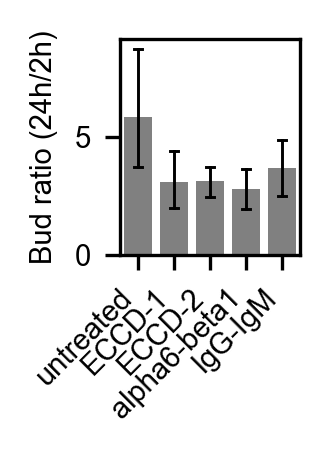

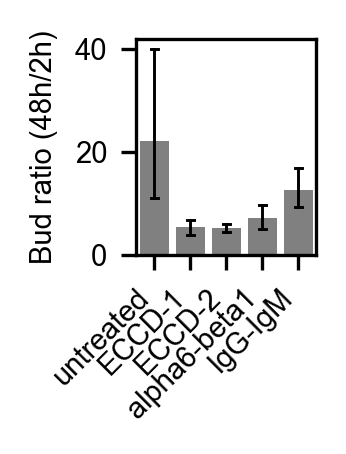

In [5]:
df_to_plot = df[df.Measurement == 'bud_count_ratio_24h_to_2h']

outputFigPath = '../jupyter_figures/' + '20200901-03-bud-count-summary-all-24-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yLabel='Bud ratio (24h/2h)',
             yMax=None, yTicks=None, fig_width=0.75, fig_height=0.9)


df_to_plot = df[df.Measurement == 'bud_count_ratio_48h_to_2h']

outputFigPath = '../jupyter_figures/' + '20200901-03-bud-count-summary-all-48-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yMax=None, yTicks=None, fig_width=0.75, fig_height=0.9)



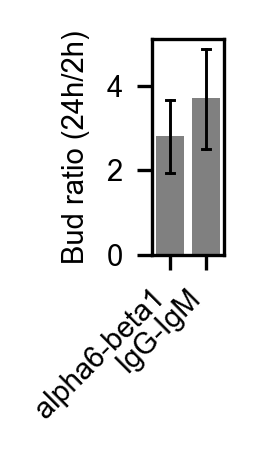

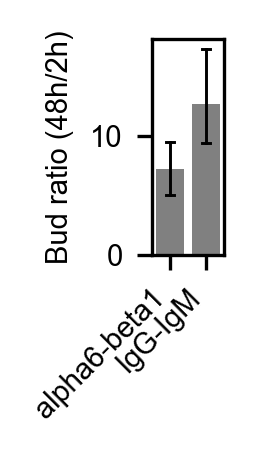

In [6]:
df_to_plot = df[(df.Measurement == 'bud_count_ratio_24h_to_2h') & (df.Treatment.isin(['alpha6-beta1', 'IgG-IgM']))]

outputFigPath = '../jupyter_figures/' + '20200901-03-bud-count-summary-integrin-set-24-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yLabel='Bud ratio (24h/2h)',
             yMax=None, yTicks=None, fig_width=0.3, fig_height=0.9)

df_to_plot = df[(df.Measurement == 'bud_count_ratio_48h_to_2h') & (df.Treatment.isin(['alpha6-beta1', 'IgG-IgM']))]

outputFigPath = '../jupyter_figures/' + '20200901-03-bud-count-summary-integrin-set-48-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yMax=None, yTicks=None, fig_width=0.3, fig_height=0.9)


In [7]:
by_treatment = df_to_plot.groupby('Treatment')
by_treatment.describe()

Value                                                           \
             count       mean       std       min       25%  50%        75%   
Treatment                                                                     
IgG-IgM        5.0  12.633333  5.085928  9.333333  9.333333  9.5  14.000000   
alpha6-beta1   5.0   7.200000  2.987009  4.000000  4.333333  8.0   8.666667   

                    
               max  
Treatment           
IgG-IgM       21.0  
alpha6-beta1  11.0

In [8]:
stats.ttest_rel(df_to_plot[df_to_plot.Treatment=='alpha6-beta1']['Value'],
                df_to_plot[df_to_plot.Treatment=='IgG-IgM']['Value'])

Ttest_relResult(statistic=-4.02009853277998, pvalue=0.015863128828624434)

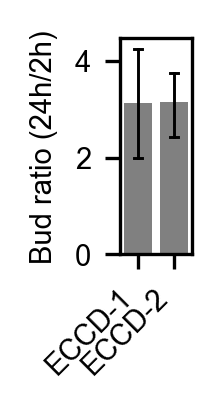

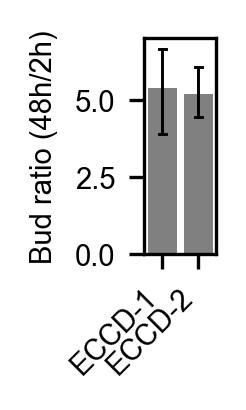

In [9]:
df_to_plot = df[(df.Measurement == 'bud_count_ratio_24h_to_2h') & (df.Treatment.isin(['ECCD-1', 'ECCD-2']))]

outputFigPath = '../jupyter_figures/' + '20200901-03-bud-count-summary-E-cadherin-set-24-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yLabel='Bud ratio (24h/2h)',
             yMax=None, yTicks=None, fig_width=0.3, fig_height=0.9)

df_to_plot = df[(df.Measurement == 'bud_count_ratio_48h_to_2h') & (df.Treatment.isin(['ECCD-1', 'ECCD-2']))]

outputFigPath = '../jupyter_figures/' + '20200901-03-bud-count-summary-E-cadherin-set-48-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yMax=None, yTicks=None, fig_width=0.3, fig_height=0.9)


In [10]:
stats.ttest_rel(df_to_plot[df_to_plot.Treatment=='ECCD-1']['Value'],
                df_to_plot[df_to_plot.Treatment=='ECCD-2']['Value'])

Ttest_relResult(statistic=0.17856007261397652, pvalue=0.8652927026887327)

In [11]:
# Read in the raw data sets to plot
# These are the E-cadherin and integrin blocking antibody treatment that was done on 9/4-9/6/2020
# This experiment has only integrin set but not the E-cadherin set

df = pd.read_csv('../data/Ecad-integrin-blocking-antibody-bud-counts/20200904-06-bud-count-summary.txt', sep='\t')
df


,Treatment,Measurement,Value
0,untreated,bud_count_2h,4.000000
1,untreated,bud_count_2h,7.000000
2,untreated,bud_count_2h,8.000000
3,untreated,bud_count_2h,5.000000
4,alpha6-beta1,bud_count_2h,6.000000
...,...,...,...
65,IgG-IgM,bud_count_ratio_48h_to_2h,15.500000
66,IgG-IgM,bud_count_ratio_48h_to_2h,8.800000
67,IgG-IgM,bud_count_ratio_48h_to_2h,10.833333
68,IgG-IgM,bud_count_ratio_48h_to_2h,9.000000


Summary of test:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
     IgG-IgM alpha6-beta1  -2.1333 0.0101 -3.7199 -0.5468   True
     IgG-IgM    untreated  -0.0994    0.9 -1.7822  1.5834  False
alpha6-beta1    untreated   2.0339  0.019  0.3512  3.7167   True
----------------------------------------------------------------
p values of all pair-wise tests:
 [0.01012012 0.9        0.01899837]
Summary of test:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
     IgG-IgM alpha6-beta1  -6.3233 0.0012 -9.8009 -2.8458   True
     IgG-IgM    untreated  -0.1883    0.9 -3.8768  3.5003  False
alpha6-beta1    untreated   6.1351 0.0024  2.4465  9.8236   True
--------------------------------------------------

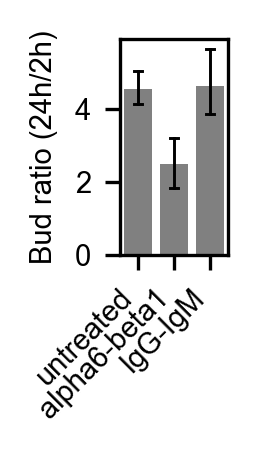

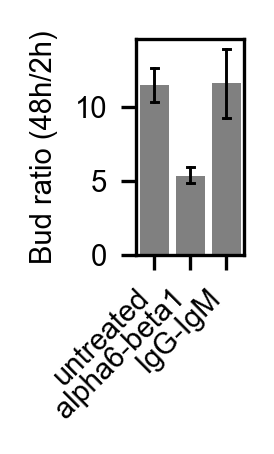

In [12]:
df_to_plot = df[df.Measurement == 'bud_count_ratio_24h_to_2h']

outputFigPath = '../jupyter_figures/' + '20200904-06-bud-count-summary-all-24-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yLabel='Bud ratio (24h/2h)',
             yMax=None, yTicks=None, fig_width=0.45, fig_height=0.9)

tukeyTest(df_to_plot.Value, df_to_plot.Treatment, alpha=0.05)


df_to_plot = df[df.Measurement == 'bud_count_ratio_48h_to_2h']

outputFigPath = '../jupyter_figures/' + '20200904-06-bud-count-summary-all-48-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yMax=None, yTicks=None, fig_width=0.45, fig_height=0.9)

tukeyTest(df_to_plot.Value, df_to_plot.Treatment, alpha=0.05)

In [13]:
tukeyTest(df_to_plot.Value, df_to_plot.Treatment, alpha=0.05)

Summary of test:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
     IgG-IgM alpha6-beta1  -6.3233 0.0012 -9.8009 -2.8458   True
     IgG-IgM    untreated  -0.1883    0.9 -3.8768  3.5003  False
alpha6-beta1    untreated   6.1351 0.0024  2.4465  9.8236   True
----------------------------------------------------------------
p values of all pair-wise tests:
 [0.00123451 0.9        0.00240462]


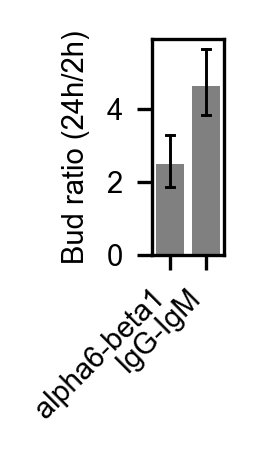

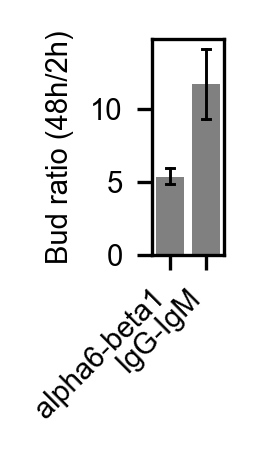

In [14]:
df_to_plot = df[(df.Measurement == 'bud_count_ratio_24h_to_2h') & (df.Treatment.isin(['alpha6-beta1', 'IgG-IgM']))]

outputFigPath = '../jupyter_figures/' + '20200904-06-bud-count-summary-integrin-set-24-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yLabel='Bud ratio (24h/2h)',
             yMax=None, yTicks=None, fig_width=0.3, fig_height=0.9)

df_to_plot = df[(df.Measurement == 'bud_count_ratio_48h_to_2h') & (df.Treatment.isin(['alpha6-beta1', 'IgG-IgM']))]

outputFigPath = '../jupyter_figures/' + '20200904-06-bud-count-summary-integrin-set-48-to-2h' + '.svg'
plotCountBar(df_to_plot.Treatment, df_to_plot.Value, outputFigPath,
             yMax=None, yTicks=None, fig_width=0.3, fig_height=0.9)


In [15]:
# Not using the paired t-test because for this set I did not keep track of paired glands from the same embryo,
# although surely the two glands of the same embryo were separated to different groups
stats.ttest_ind(df_to_plot[df_to_plot.Treatment=='alpha6-beta1']['Value'],
                df_to_plot[df_to_plot.Treatment=='IgG-IgM']['Value'])

Ttest_indResult(statistic=-4.506014511483958, pvalue=0.001986241348307924)

In [19]:
def change_bar_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

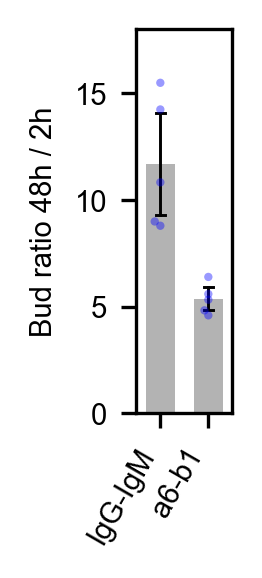

In [22]:
# Swarm and bar plot of different collagenase concentrations

outputPrefix = '20200904-06-bud-count-summary-integrin-set-48-to-2h'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.4
fig_height=1.6
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x='Treatment', y='Value', data = df_to_plot,
                   order=['IgG-IgM', 'alpha6-beta1'],
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(x='Treatment', y='Value', data = df_to_plot,
                 order=['IgG-IgM', 'alpha6-beta1'],
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 18)
# plt.yticks([0, 10, 20])

plt.xlabel(None)
plt.ylabel("Bud ratio 48h / 2h")

# rotate x tick labels if necessary
x_labels = ['IgG-IgM', 'a6-b1']
ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)
